# PSF Extractor
---

#### Overview
PSF extractor walkthrough

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## 1) Set parameters
Trackpy takes expected feature diameters in ($z$, $y$, $x$) as input. Requires input diameters to be odd and recommends rounding up.

In [3]:
# Set pixel sizes [nm/px]
psx = 64
psy = psx
psz = 125

# Set optical parameters:
NA = 0.85  # numerical aperture
lambda_em = 520  #emission wavelength

# Set expected feature diameters [nm]
dx_nm = 0.5 * lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Output
out = f"""\
Optical settings
----------------
NA............ {NA:.2f}
Wavelength.... {lambda_em:.0f} nm
Pixelsize x... {psx:.1f} nm/px
Pixelsize y... {psy:.1f} nm/px
Pixelsize z... {psz:.1f} nm/px
Diameter x.... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y.... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z.... {dz:.0f} px ({dz_nm:.1f} nm)
"""
print(out)

Optical settings
----------------
NA............ 0.85
Wavelength.... 520 nm
Pixelsize x... 64.0 nm/px
Pixelsize y... 64.0 nm/px
Pixelsize z... 125.0 nm/px
Diameter x.... 5 px (305.9 nm)
Diameter y.... 5 px (305.9 nm)
Diameter z.... 9 px (917.6 nm)



#### Spicy colormap

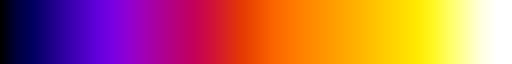

In [4]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

## 1) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

In [5]:
import trackpy
from psf_extractor import load_stack, plot_mip

### Create stack

In [6]:
# Set directory of image stack
file_pattern = '../data/sample_zstack_png_sequence/'
# Load image stack
stack = load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/32 [00:00<?, ?it/s]

INFO:root:(32, 2048, 2448) image stack created succesfully.


### Maximum intensity projection in `z`

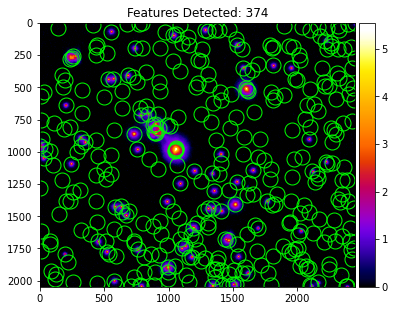

In [7]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
df_features = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)
N_features = len(df_features)

# Plot MIP
plot_mip(mip, features=df_features)

## 2) Mass-based filtering

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

In [8]:
from ipywidgets import interact, fixed, FloatLogSlider
from psf_extractor import get_min_masses, get_max_masses, plot_mass_range_interactive

#### Choose minimum mass

In [9]:
# Choose minimum mass range
min_masses = get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(df_features),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=2.4639943838277563, description='mass', max=1.6926697092718745, min…

In [10]:
# Set minimum mass
min_mass = widget.widget.children[0].value

# Filter out dim features
df_min = df_features.loc[df_features['raw_mass'] > min_mass]

#### Choose maximum mass

In [11]:
# Get candidate minimum masses
max_masses = get_max_masses(min_mass, b=20, n=31)

widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(df_min),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=11.019317876833144, description='mass', max=1.6926697092718745, min…

In [12]:
# Set minimum mass
max_mass = widget.widget.children[0].value
# Filter out super bright features
df_max = df_min.loc[df_min['raw_mass'] < max_mass]
# Apply filtering to official feature DataFrame
df_features = df_features.loc[(df_features['raw_mass'] > min_mass) &\
                              (df_features['raw_mass'] < max_mass)]

# Output
out = f"""\
Minimum mass.................. {min_mass:.2f}
Maximum mass.................. {max_mass:.2f}
Detected features (initial)... {N_features:.0f}
Too dim (min filtered)........ {N_features-len(df_min):.0f}
Too bright (max filtered)..... {len(df_min)-len(df_max):.0f}
Remaining features............ {len(df_features):.0f}
Random sample of features.....
"""
print(out)
df_features.sample(5)

Minimum mass.................. 2.46
Maximum mass.................. 11.02
Detected features (initial)... 374
Too dim (min filtered)........ 305
Too bright (max filtered)..... 4
Remaining features............ 65
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep
73,406.078884,682.842231,0.584155,1.356995,0.136152,0.064234,5.368628,0.003255
182,1075.158892,2218.097668,0.319307,1.375547,0.100977,0.033513,2.921569,0.006039
168,986.083503,1057.816701,0.228542,1.357637,0.147894,0.025135,8.047059,0.002164
359,2023.060192,1520.807114,0.340253,1.369494,0.131245,0.036306,3.345098,0.005260
354,1999.077458,578.022840,0.468720,1.385483,0.099014,0.046546,4.392157,0.003989


## 3) Filter out overlapping features

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box.

In [16]:
from psf_extractor import remove_overlapping_features, plot_overlapping_features

In [14]:
# Set dimensions of bounding box based on expected feature diameter
wx = 10*dx_nm/psx  # px
wy = 10*dy_nm/psy  # px

# Remove overlapping features
df, overlapping = remove_overlapping_features(df_features, wx=wx, wy=wy, return_indices=True)

  0%|          | 0/2080 [00:00<?, ?it/s]

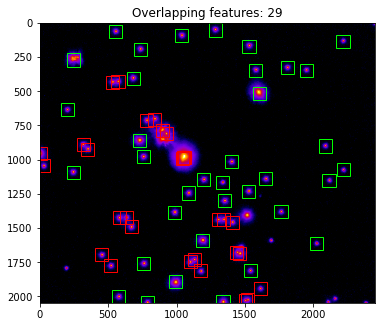

In [17]:
plot_overlapping_features(mip, df_features, overlapping, width=wx)

## 4) Localize features
---
The idea is to overlay all of the individual PSFs in the image stack to derive an average PSF. In order to do this, the individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. This is accomplished by first fitting a 2D Gaussian to the maximum intensity projection of each PSF (to get the $x$, $y$ position), and then by fitting a 1D Gaussian to the resulting line profile through the center of the PSF (to get the $z$ position).

#### Process
1. The PSF is extracted from each (previously detected) feature
1. Outlier PSFs are filtered out
1. Localization via Gaussian fits

### Extract PSFs

In [ ]:
from psf_extractor import extract_psfs

In [ ]:
# Set dimensions of subvolume [μm]
wx_um = dx_um
wy_um = wx_um
wz_um = dx_um*3

# Convert dimensions of subvolume [μm --> px]
wx = (wx_um / psx * 1e3)
wy = (wy_um / psy * 1e3)
wz = (wz_um / psz * 1e3)

# Compile dimensions (z, y, x)
shape_psf = [wz, wy, wx]
shape_psf

#### Plot maximum intensity projections of extracted PSFs

In [ ]:
# Extract PSFs
psfs, df_features_ = extract_psfs(stack, df_features, shape_psf)

# Create figure
ncols = 8
nrows = int(np.ceil(len(psfs) / ncols))
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
for i, psf in enumerate(psfs):
    ax = axes.flat[i]
    mip = np.max(psf, axis=0)
    ax.imshow(mip, cmap=fire)
# Remove empty subplots
[fig.delaxes(axes.flat[-i-1]) for i in range(ncols*nrows - len(psfs))];

### Filter out strange PSFs
Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls outside the acceptable range ($\mu_{PCC} \,\pm\, 3\sigma_{PCC}$).

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but $3\times$ the average number of occurences seems to work empirically.

In [ ]:
from itertools import combinations
from scipy.stats import pearsonr

In [ ]:
# Collect PCCs
pccs = []
# Iterate through every (unique) pair of PSFs
ij = list(combinations(range(len(psfs)), 2))
for i, j in tqdm(ij, total=len(ij)):

    # Get pairs of PSFs
    mip_i = np.max(psfs[i], axis=0)
    mip_j = np.max(psfs[j], axis=0)
    # Calculate PCC of maximum intensity projections
    pcc, _ = pearsonr(mip_i.ravel(),
                      mip_j.ravel())
    pccs.append(pcc)

# Convert to array
pccs = np.array(pccs)

In [ ]:
# Get distribution
hist, bins = np.histogram(pccs, bins=32)
bins = (bins[1:] + bins[:-1]) / 2

# Outlier criteria
pcc_min = pccs.mean() - 1*pccs.std()
pcc_max = pccs.mean() + 1*pccs.std()

# Plot distribution
fig, ax = plt.subplots()
ax.plot(bins, hist)
ax.fill_between(bins, 0, hist, alpha=0.3)
# Plot outlier range
ax.axvline(pcc_min, ymax=0.75, color='k', ls='--')
ax.axvline(pcc_max, ymax=0.75, color='k', ls='--')
# Aesthetics
ax.grid(ls=':')
ax.set_xlabel('PCC [AU]')
ax.set_ylabel('Freq')
ax.set_title('Distribution of PCCs');

In [ ]:
# Get indices of candidate outliers
suspects_i = np.argwhere((pccs < pcc_min) |\
                         (pccs > pcc_max))
# Convert to indices of PSF pairs
suspects_ij = np.array(ij)[suspects_i[:, 0]]

# Determine frequency of out lying (?)
i, counts = np.unique(suspects_ij, return_counts=True)
outliers = i[counts > 3*counts.mean()]
outliers

In [ ]:
# Remove outliers
df_features_ = df_features_.drop(outliers)
df_features_.head()

### Least squares fitting
* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [ ]:
from scipy.optimize import curve_fit

from psf_extractor import (gaussian_1D, fit_gaussian_1D,
                           gaussian_2D, fit_gaussian_2D)

In [ ]:
# Re-extract PSFs based on updated feature set
psfs, df_features = extract_psfs(stack, df_features_, shape_psf)

In [ ]:
# Initialize localization DataFrame
columns = ['x0', 'y0', 'z0', 'sigma_x', 'sigma_y', 'sigma_z']
df_loc = pd.DataFrame(columns=columns)

# Loop through PSFs
for i, psf in enumerate(psfs):

    # 2D Fit
    # ------
    # Take maximum intensity projection
    mip = np.max(psf, axis=0)
    x0, y0, sigma_x, sigma_y, A, B = fit_gaussian_2D(mip)

    # 1D Fit
    # ------
#     # Slice in through x0, y0
#     z_slice = psf[:,int(y0),int(x0)]
#     z0, sigma_z, A, B = fit_gaussian_1D(z_slice)
    # Integrate over x and y
    z_sum = psf.sum(axis=(1, 2))
    z0, sigma_z, A, B = fit_gaussian_1D(z_sum)
    # Populate DataFrame
    df_loc.loc[i, columns] = [x0, y0, z0, sigma_x, sigma_y, sigma_z]

# Preview DataFrame
df_loc.head()

#### Plot localization data

In [ ]:
from psf_extractor import plot_psf_localizations

In [ ]:
plot_psf_localizations(df_loc)

## Characterize PSF
---

#### Quick upsampling demo

In [ ]:
from skimage.transform import resize

In [ ]:
# Crop the central spot from a random psf
w = 20
i = np.random.randint(len(psfs))
Nz, Ny, Nx = psfs[i].shape
image = psfs[i][Nz//2,
                Ny//2-w//2: Ny//2+w//2,
                Nx//2-w//2: Nx//2+w//2].copy()

# Upsample with nearest-neighbor interpolation
image_k0 = resize(image, output_shape=(2*w, 2*w), order=0)
image_k1 = resize(image, output_shape=(2*w, 2*w), order=1)

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
axes[0].imshow(image, cmap=fire)
axes[1].imshow(image_k0, cmap=fire)
axes[2].imshow(image_k1, cmap=fire)
# Aesthetics
axes[0].set_title('Original image')
axes[1].set_title('Nearest neighbor upsampling')
axes[2].set_title('Bi-linear upsampling');

### Upsample and align PSFs

In [ ]:
def align_psfs(psfs, locations, upsample_factor=2):
    """Upsample, align, and sum PSFs

    psfs : list or array-like
        List of PSFs
    locations : `pd.DataFrame`
        Localization data with z0, y0, and x0 positions

    Returns
    -------
    psf_sum : array-like
        Aligned and summed together PSFs
    """
    usf = upsample_factor
    psf_sum = 0
    for i, psf in tqdm(enumerate(psfs), total=len(psfs)):

        # Upsample PSFs
        psf_up = psfs[i].repeat(usf, axis=0)\
                        .repeat(usf, axis=1)\
                        .repeat(usf, axis=2)

        # From fit
        z0, y0, x0 = usf * df_loc.loc[i, ['z0', 'y0', 'x0']]
        # PSF center
        zc, yc, xc = (psf_up.shape[0]//2,
                      psf_up.shape[1]//2,
                      psf_up.shape[2]//2)

        # Multidimensional ~roll~
        dz, dy, dx = int(zc-z0), int(yc-y0), int(xc-x0)
        psf_up_a = np.roll(psf_up, shift=(dz, dy, dx), axis=(0, 1, 2))

        # Sum PSFs
        psf_sum += psf_up_a

    return psf_sum

In [ ]:
psf_sum = align_psfs(psfs, df_loc, upsample_factor=5)

In [ ]:
def crop_psf(psf):
    """"""
    # Get dimensions
    Nz, Ny, Nx = psf.shape
    Nmin = np.min([Nz, Ny, Nx])

    # Crop total psf to a cube defined by the smallest dimension
    z1, z2 = (Nz-Nmin)//2, Nz - ((Nz-Nmin)//2) - Nz % 2
    y1, y2 = (Ny-Nmin)//2, Ny - ((Ny-Nmin)//2) - Ny % 2
    x1, x2 = (Nx-Nmin)//2, Nx - ((Nx-Nmin)//2) - Nx % 2
    psf_cube = psf[z1:z2, y1:y2, x1:x2]

    return psf_cube

In [ ]:
def plot_psf(psf, crop=True):
    """"""

    # Create figure and axes
    fig = plt.figure(figsize=(11, 11))
    gs = fig.add_gridspec(6, 6)
    ax_xy = fig.add_subplot(gs[:3,:3])
    ax_yz = fig.add_subplot(gs[:3,3:])
    ax_xz = fig.add_subplot(gs[3:,:3])
    ax_z = fig.add_subplot(gs[-3,3:])
    ax_y = fig.add_subplot(gs[-2,3:])
    ax_x = fig.add_subplot(gs[-1,3:])

    # Crippity crop crop
    if crop:
        psf = crop_psf(psf)

    # PSF dimensions
    Nz, Ny, Nx = psf.shape
    # PSF volume
    dz, dy, dx = psz*Nz, psy*Ny, psx*Nx
    # PSF center coords
    z0, y0, x0 = Nz//2, Ny//2, Nx//2

    # Plot 2D PSFs (slices)
    ax_xy.imshow(psf[z0,:,:], cmap=fire)
    ax_yz.imshow(psf[:,y0,:], cmap=fire)
    ax_xz.imshow(psf[:,:,x0], cmap=fire)
    # 1D PSFs (slices)
    prof_z = psf[:,y0,x0]
    prof_y = psf[z0,:,x0]
    prof_x = psf[z0,y0,:]
    # Plot 1D PSFs
    plot_kwargs = {'ms': 5, 'marker': 'o', 'ls': '', 'alpha': 0.75}
    ax_z.plot(prof_z, c='C1', label='Z', **plot_kwargs)
    ax_y.plot(prof_y, c='C0', label='Y', **plot_kwargs)
    ax_x.plot(prof_x, c='C2', label='X', **plot_kwargs)

    # Do 1D PSF fits
    u = np.linspace(0, Nz, Ny*Nx)
    popt_z = fit_gaussian_1D(prof_z)
    popt_y = fit_gaussian_1D(prof_y)
    popt_x = fit_gaussian_1D(prof_x)

    # Plot 1D PSF fits
    ax_z.plot(u, gaussian_1D(u, *popt_z), 'k-',
              label=f'{popt_z[1]:.2f}nm\nFWHM')
    ax_y.plot(u, gaussian_1D(u, *popt_y), 'k-',
              label=f'{popt_y[1]:.2f}nm\nFWHM')
    ax_x.plot(u, gaussian_1D(u, *popt_x), 'k-',
              label=f'{popt_x[1]:.2f}nm\nFWHM')

    # Aesthetics
    [ax.legend(loc='upper right') for ax in [ax_z, ax_y, ax_x]]
    [ax.grid(ls=':') for ax in [ax_z, ax_y, ax_x]]
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [ ]:
plot_psf(psf_sum)

In [ ]:
output_shape = [n//5 for n in psf_sum.shape]
plot_psf(resize(psf, output_shape=output_shape, anti_aliasing=True))